Выполнить классификацию изображений на наборе notMNIST_small.

In [1]:
from google.colab import drive
from tqdm import tqdm

from tensorflow.keras.layers import Conv2D, Dropout, Dense, BatchNormalization, Flatten, Rescaling, Input, RandomBrightness, RandomContrast, RandomFlip, RandomRotation, ReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import tensorflow as tf

import zipfile
import pathlib
import cv2
import os


In [4]:
# mount drive folder
drive.mount(mountpoint='/content/drive')


Mounted at /content/drive


Разархивируем набор данных, проврим каждое изобржение и те, которые не удалось открыть, удалим. Определим рарешение изображений и содадим набор данных с помощью tensorflow.

In [6]:
# initialize constants
MNIST_ZIP_PATH = '/content/drive/MyDrive/temp/notMNIST_small.zip'
EXTRACT_PATH = '/'.join(MNIST_ZIP_PATH.split('/')[:-1])
EXTRACTED_FOLDER = MNIST_ZIP_PATH.split('/')[-1].split('.')[0]

BATCH_SIZE = 64
TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.1
N_EPOCHS = 10


In [7]:
# extract zip archive if it is not already extracted
# check every image in dataset, because there are empty images here
# delete empty images

if not EXTRACTED_FOLDER in os.listdir(EXTRACT_PATH):
    with zipfile.ZipFile(MNIST_ZIP_PATH, 'r') as mnist_zip_file:
        mnist_zip_file.extractall(EXTRACT_PATH)

    counter = 0
    for folder_name in os.listdir(os.path.join(EXTRACT_PATH, EXTRACTED_FOLDER)):
        for image_name in tqdm(os.listdir(os.path.join(EXTRACT_PATH,
                                                       EXTRACTED_FOLDER,
                                                       folder_name))):
            image_path = os.path.join(EXTRACT_PATH, EXTRACTED_FOLDER,
                                      folder_name, image_name)
            try:
                cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).shape
            except:
                counter += 1
                os.remove(image_path)
                print('\n', folder_name, '->', image_name)

    print('\nNumber of crushed images:', counter)


 70%|███████   | 1316/1873 [00:20<00:02, 205.95it/s]


 A -> RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png


 24%|██▎       | 443/1873 [00:15<00:07, 200.61it/s]


 F -> Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png


100%|██████████| 1872/1872 [00:25<00:00, 73.01it/s] 


Number of crushed images: 2


In [8]:
# get images width and height
folder_name = os.listdir(os.path.join(EXTRACT_PATH, EXTRACTED_FOLDER))[0]
image_name = os.listdir(os.path.join(EXTRACT_PATH, EXTRACTED_FOLDER, folder_name))[0]
image_path = os.path.join(EXTRACT_PATH, EXTRACTED_FOLDER, folder_name, image_name)

temp_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
w, h = temp_image.shape

print(f'Image shape is {w}x{h} px')


Image shape is 28x28 px


In [9]:
# loat mnist dataset from directory
mnist_dataset = image_dataset_from_directory(os.path.join(EXTRACT_PATH,
                                                          EXTRACTED_FOLDER),
                                             batch_size=BATCH_SIZE,
                                             image_size=(w, h),
                                             color_mode='grayscale')
print(mnist_dataset.class_names)


Found 18724 files belonging to 10 classes.
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']


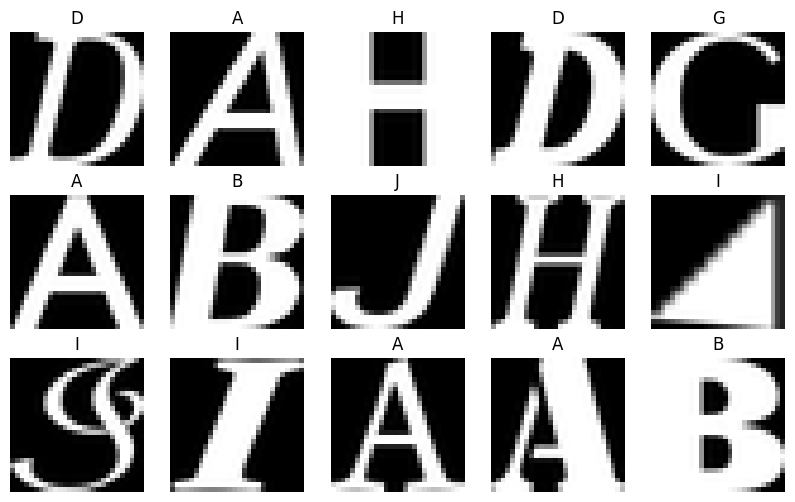

In [ ]:
# show dataset pictures
plt.figure(figsize=(10, 6))

for images, labels in mnist_dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'), cmap='gray')
        plt.title(mnist_dataset.class_names[labels[i]])
        plt.axis('off')


In [10]:
# calculate train and validation batches count
# and create train, validation and test sets

batches_count = tf.data.experimental.cardinality(mnist_dataset).numpy()
train_batches_count = int(batches_count * TRAIN_SPLIT)
val_batches_count = int(batches_count * VAL_SPLIT)

test_dataset = mnist_dataset.skip(train_batches_count + val_batches_count)
train_dataset = mnist_dataset.take(train_batches_count + val_batches_count).skip(val_batches_count)
val_dataset = mnist_dataset.take(val_batches_count)

print('Train batches count:',
      tf.data.experimental.cardinality(train_dataset).numpy(),
      '\nValidation batches count:',
      tf.data.experimental.cardinality(val_dataset).numpy(),
      '\nTest batches count:',
      tf.data.experimental.cardinality(test_dataset).numpy())


Train batches count: 205 
Validation batches count: 29 
Test batches count: 59


Создадим дополнительно слои для аугументации данных, расширим тренеровочный набор данных в два раза.

In [11]:
# create augumentations layers for extending images set
augument_layers = tf.keras.Sequential([
    Input(shape=(w, h, 1,)),
    RandomBrightness(0.1),
    RandomContrast(0.1),
    RandomRotation(0.1, fill_mode='constant')
])

augument_layers.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_brightness (RandomBrightness) │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast (RandomContrast)     │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Letter G 



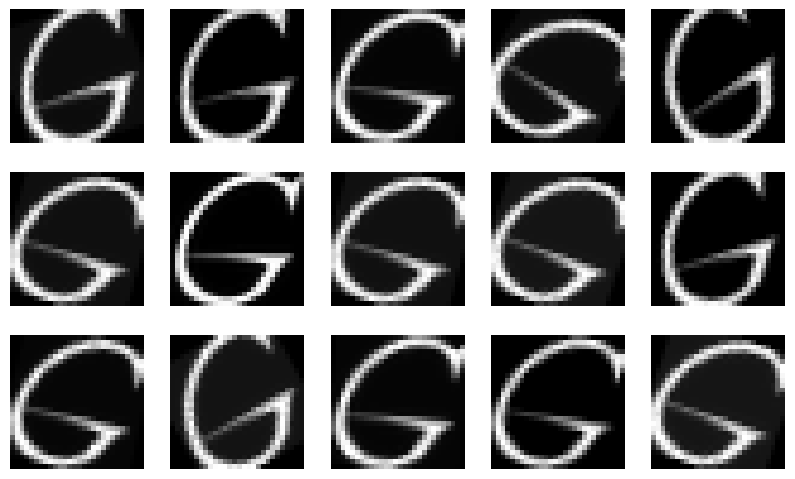

In [ ]:
# show augumented pictures
plt.figure(figsize=(10, 6))

for images, labels in mnist_dataset.take(1):
    print('Letter', mnist_dataset.class_names[labels[0]], '\n')

    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        augument_images = augument_layers(images)
        plt.imshow(augument_images[0].numpy().astype('uint8'), cmap='gray')
        plt.axis('off')


In [12]:
# extend training dataset with augumented images
augumented_dataset = None

for images, labels in train_dataset.take(len(train_dataset)):
    augumented_images = augument_layers(images)
    ds = tf.data.Dataset.from_tensor_slices((augumented_images, labels))

    if not augumented_dataset:
        augumented_dataset = ds
    else:
        augumented_dataset = augumented_dataset.concatenate(ds)

augumented_dataset = augumented_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.concatenate(augumented_dataset)
train_dataset = train_dataset.shuffle(buffer_size=100)

print('Extended train dataset batches count:',
      tf.data.experimental.cardinality(train_dataset).numpy())


Extended train dataset batches count: 410


In [13]:
# build network model
model = tf.keras.Sequential()
model.add(Input(shape=(w, h, 1,)))
model.add(Rescaling(scale=1. / 255))

for _ in range(4):
    model.add(Conv2D(512, 3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

model.add(Conv2D(512, 2, strides=2, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())

for _ in range(4):
    model.add(Conv2D(512, 3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

model.add(Conv2D(512, 2, strides=2, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())

model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(4096))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.5))

model.add(Dense(1000))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.2))

model.add(Dense(len(mnist_dataset.class_names), activation='softmax'))

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 512)         │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 28, 28, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 28, 28, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 28, 28, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 28, 28, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 512)         │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 14, 14, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 14, 14, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 126,044,050 (480.82 MB)

 Trainable params: 126,022,594 (480.74 MB)

 Non-trainable params: 21,456 (83.81 KB)

In [14]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])


In [15]:
# create callbacks for saving model and reduce learning rate
best_model_path = '/content/drive/MyDrive/temp/model_best.keras'
model_saving = ModelCheckpoint(best_model_path, save_best_only=True,
                               monitor='val_loss', mode='min')
lr_reducing = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,
                                mode='min')


In [16]:
# train model
history = model.fit(train_dataset, validation_data=val_dataset,
                    callbacks=[model_saving, lr_reducing],
                    epochs=N_EPOCHS, verbose=2)


Epoch 1/10
410/410 - 225s - 548ms/step - accuracy: 0.8728 - loss: 0.4205 - val_accuracy: 0.6530 - val_loss: 1.6500 - learning_rate: 0.0010
Epoch 2/10
410/410 - 197s - 481ms/step - accuracy: 0.9259 - loss: 0.2429 - val_accuracy: 0.9310 - val_loss: 0.2326 - learning_rate: 0.0010
Epoch 3/10
410/410 - 223s - 545ms/step - accuracy: 0.9353 - loss: 0.2035 - val_accuracy: 0.9467 - val_loss: 0.2049 - learning_rate: 0.0010
Epoch 4/10
410/410 - 205s - 500ms/step - accuracy: 0.9449 - loss: 0.1769 - val_accuracy: 0.9461 - val_loss: 0.1990 - learning_rate: 0.0010
Epoch 5/10
410/410 - 236s - 576ms/step - accuracy: 0.9504 - loss: 0.1557 - val_accuracy: 0.9494 - val_loss: 0.1881 - learning_rate: 0.0010
Epoch 6/10
410/410 - 206s - 503ms/step - accuracy: 0.9523 - loss: 0.1446 - val_accuracy: 0.9445 - val_loss: 0.1836 - learning_rate: 0.0010
Epoch 7/10
410/410 - 200s - 488ms/step - accuracy: 0.9594 - loss: 0.1253 - val_accuracy: 0.9510 - val_loss: 0.1639 - learning_rate: 0.0010
Epoch 8/10
410/410 - 184s -

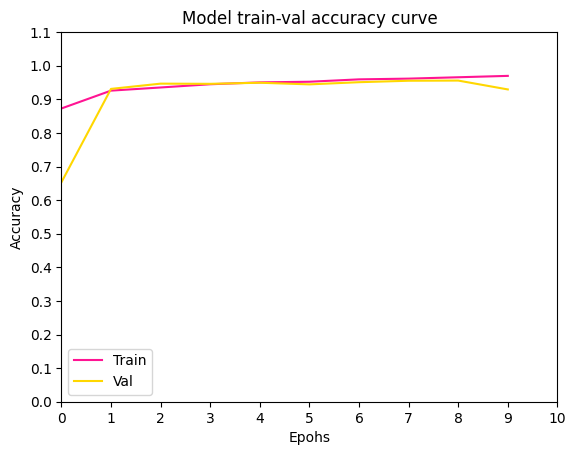

In [21]:
# vidualize model training metrics
plt.plot(history.history['accuracy'], color='deeppink')
plt.plot(history.history['val_accuracy'], color='gold')
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.1))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.title('Model train-val accuracy curve')
plt.legend(['Train', 'Val'])
plt.xlim(0, N_EPOCHS)
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.xlabel("Epohs")
plt.show()


In [18]:
# load best model from file
best_model = load_model(best_model_path)


In [19]:
# evaluate best model
metrics = best_model.evaluate(test_dataset)


59/59 ━━━━━━━━━━━━━━━━━━━━ 55s 233ms/step - accuracy: 0.9548 - loss: 0.1749


Таким обраом, для классификации картинок букв составлена нейронная сеть из сверточных слоев, линейных слоев, слоев нормализации и исключающих слоев. Данные для обучения расширены аугументированием. И в итоге точность классификации на тестовой выборке получилась 0.9548.